In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import astropy.constants as cte
import astropy.units as un
import astropy.cosmology
from astropy.cosmology import Planck15 as cosmo
import emcee
import scipy.optimize as op
import corner
import scipy

In [2]:
c=cte.c
c_um=c.to("um/s")
c_mm=c.to("mm/s")
Msun=cte.M_sun

In [3]:
file = open("/Users/mariajesusfloresmoraga/Desktop/DSFG/SPT.csv")
csvreader = csv.reader(file)
header = []
header = next(csvreader)

rows = []
for row in csvreader:
        rows.append(row)

ID= []

z=[]

S3=[]
errS3=[]

S2=[]
errS2=[]

S1=[]
errS1=[]

S870=[]
errS870=[]

S500=[]
errS500=[]

S350=[]
errS350=[]

S250=[]
errS250=[]

S160=[]
errS160=[]

S100=[]
errS100=[]

for j in rows:   
    
    ID.append(j[0])
    z.append(float(j[1]))
    S3.append(float(j[2]))
    errS3.append(float(j[3]))
    S2.append(float(j[4]))
    errS2.append(float(j[5]))
    S1.append(float(j[6]))
    errS1.append(float(j[7]))
    S870.append(float(j[8]))
    errS870.append(float(j[9]))
    S500.append(float(j[10]))
    errS500.append(float(j[11]))
    S350.append(float(j[12]))
    errS350.append(float(j[13]))
    S250.append(float(j[14]))
    errS250.append(float(j[15]))
    S160.append(float(j[16]))
    errS160.append(float(j[17]))
    S100.append(float(j[18]))
    errS100.append(float(j[19]))
   

In [196]:
v__=np.array([870,500,350,250,160,100])*un.um
v_=(c_um/v__).to("Hz")
v=v_.value
l__=np.array([3.2,2,1.4])*un.mm
l_=(c_mm/l__).to("Hz")
l=l_.value
vf=np.concatenate((l,v))
print(vf)

[9.36851431e+10 1.49896229e+11 2.14137470e+11 3.44589032e+11
 5.99584916e+11 8.56549880e+11 1.19916983e+12 1.87370286e+12
 2.99792458e+12]


In [197]:
def tau(z,M_,d_,vf): 
    v0=353*un.GHz
    b=2
    M=Msun * 10** M_
    k0=0.15*(un.m**2/un.kg) 
    tau=k0*(vf/v0)**b *(z+1)**b * M/(np.pi*(d_/2)**2)
    return tau.to("")

In [198]:
def P(vf,T,z):
    h=cte.h
    K=cte.k_B
    A=2*h/(c**2)
    a=(h*vf*(1+z)/(K*T))
    B=vf**3/(np.e**(a.value) -1)
    P=(A*B).to("mJy")
    return P

In [199]:
def modelSv(z,T,M_,d_,vf):
    b=2
    v0=353*un.GHz
    D=cosmo.angular_diameter_distance(z)
    M=Msun*(10**M_)
    d=d_
    O=np.pi*(d/2)**2 * (D**-2)
    S_=O*(1-np.e**-tau(z,M_,d_,vf))*P(vf,T,z)
    S=S_.to("mJy")
    return S

In [955]:
def A(z,Tc,M_,d_,vf): 
    v0=353*un.GHz
    b=2
    Tvariable=(np.linspace(Tc.value,1000,10000)) *un.K
    integrales=[]
    for i in vf:
        integrales.append(scipy.integrate.trapz(modelSv(z,Tvariable,M_,d_,i)*(Tvariable)**-7,x=Tvariable))
    return integrales

In [940]:
def modelSobs(z,Tc,M_,d_,vf): #Como SPT no entrega Tc tomamos Tc= T-10
    b=2
    v0=353*un.GHz
    D=cosmo.angular_diameter_distance(z)
    TCMB=2.725*un.K
    O=np.pi*(d_/2)**2 * (D**-2)
    integral=A(z,Tc,M_,d_,vf)
    h=cte.h
    K=cte.k_B
    model_=[]
    for j in range(len(vf)):
        M1=6 * Tc**6 * integral[j]
    
        M2=O * np.e**-tau(z,M_,d_,v0) * (2*h)/(c**2) * (vf[j]**3)/(np.e**(h*vf[j]/(K*TCMB))-1)
        model_.append((M1+M2).value)
    model=model_*un.mJy

    return model

In [1124]:
z_ref=4    #datos sacados del prom de los datos de SPT
T_ref=65.2*un.K
Tc_ref=T_ref-10*un.K
M_ref=np.log10(2*1.02*10**9) #U M
d_ref=4.1*un.kpc

SPT0002-52

In [1125]:
model_S_0=modelSv(z_ref,T_ref,M_ref,d_ref,vf*un.Hz)
model_PL_0=modelSobs(z_ref,Tc_ref,M_ref,d_ref,vf*un.Hz) 

In [1126]:
model_PL_0

<Quantity [  2.02911058,   8.97594509,  27.87695031, 102.73967017,
           249.38338197, 286.16538793, 244.75488349, 122.94070038,
            36.01015185] mJy>

In [1127]:
model_S_0-model_PL_0

<Quantity [ -0.55486596,  -0.87306432,  -1.29265919,  -3.70592297,
           -15.87015258, -32.82086809, -53.71308817, -62.74342721,
           -32.07851888] mJy>

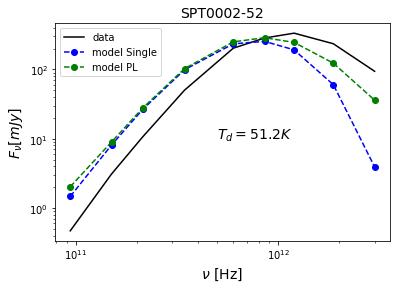

In [1128]:
plt.plot(vf,frecs0T,"k",label="data") #esto es solo para ir viendo un poco los valores de ref.
plt.plot(vf,model_S_0,marker="o",ls="--",c="b",label="model Single")
plt.plot(vf,model_PL_0,marker="o",ls="--",c="g",label="model PL")
#plt.errorbar(v,frecs0[0],errf0[0],marker="o",markersize=8,markerfacecolor='red',c="k",label="ACT")
#plt.errorbar(l,frecs0[1],errf0[1],marker="o",markersize=8,markerfacecolor='blue',c="k",label="Herschel")
plt.xlabel(r"$\nu$ [Hz]",fontsize=14)
plt.ylabel(r"$F_{\nu} [mJy]$",fontsize=14)
plt.title("{}".format(ID[0]),fontsize=14)
plt.annotate(r"$T_{d}=51.2K$",(5*10**11,10),fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [1129]:
def fit_bb(x, *p): #p not a list, x va en Hz
    #dejar una descripcion de los parametros que entran en la funcion entre comillas al comienzo
    """
    x : frecuencia *un.Hz ------> por alguna razon esto esta en Hz pero el v0 por ejemplo en GHz
    p = z T M d  ---------------> parametros a fitear   
    z : redshift (adimensional)
    T : temperatura cut-off en Kelvin pero sin usar unidades
    M : log(mu M/M_sun) (adimensional)
    d : distance *en kpc pero sin usar unidades
    
    return: modelo en mJy pero sin unidades
    """
    #queda definido dentro el valor de b y v0 que no se cambian nunca
    b = 2.0
    v0 = 353*un.GHz

    return modelSobs(p[0],p[1]*un.K,p[2],p[3]*un.kpc,x)

In [1130]:
def lnlike(theta,x,y,yerr):
    lnf,z,Tc,M,d = theta
    x = x*un.Hz
    modelSobs = fit_bb(x,z,Tc,M,d).value
    inv_sigma2 = 1.0 / (yerr**2 + (modelSobs)**2 * np.exp(2*lnf))
    return -0.5 * np.sum((y-(modelSobs))**2*inv_sigma2 - np.log(inv_sigma2))

In [1131]:
def lnprior(theta):
    lnf,z,Tc,M,d = theta
    if lnf<=-1 and Tc>0 and z>0 and M>0 and d>0:
        return -1 * (Tc - 40)**2 / (5 * 10**2) #example gaussian
    return -np.inf

In [1132]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not(np.isfinite(lp)):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [1133]:
def ml(ID,z,Tc,M_,d_,frecsT,errfT): #recibe con unidades

    theta = [-1,z,Tc.value,M_,d_.value]
     

    n = lambda *args: -lnlike(*args)

    maxlike = op.minimize(n, theta, args=(vf,np.array(frecsT),np.array(errfT)))
    
    lnfM,zm,Tcm,Mm,dm = maxlike["x"]
    
    plt.figure(figsize=(12,9))


    x0 = np.linspace(100,2000,200)*un.GHz
    x0 = x0.to("Hz")
        
    pm = [zm,Tcm,Mm,dm]

    y = fit_bb(x0,pm[0],pm[1],pm[2],pm[3])

    plt.plot(x0,y,label="MaxL")
    plt.errorbar(vf,np.array(frecsT),yerr=np.array(errfT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(zm,2),np.round(Tcm,2),np.round(Mm,2),np.round(dm,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

In [1134]:
def mcmc(ID,z,Tc,M_,d_,frecsT,errfT): #recibe con unidades, T=Tc =Td-10

    theta = [-1,z,Tc.value,M_,d_.value]
     

    n = lambda *args: -lnlike(*args)

    maxlike = op.minimize(n, theta, args=(vf,np.array(frecsT),np.array(errfT)))
    
    lnfM,zm,Tcm,Mm,dm = maxlike["x"]
    
    plt.figure(figsize=(12,9))


    x0 = np.linspace(100,2500,200)*un.GHz
    x0 = x0.to("Hz")
    
        
    pm = [zm,Tcm,Mm,dm]

    y = fit_bb(x0,pm[0],pm[1],pm[2],pm[3])

    ndim, nwalkers = 5, 1000 # 6000 iteraciones
    pos = [maxlike["x"] + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,args=(vf,np.array(frecsT),np.array(errfT)),
                                threads=2)
    sampler.run_mcmc(pos, 100) #16 chains
    samples = sampler.chain[:, 90:, :].reshape((-1, ndim))
    
    fig = corner.corner(samples,
                    labels=["ln","z", "T", r"$M$", r"$d$"],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    truths=[lnfM,zm,Tcm,Mm,dm])

SPT0002-52

In [1135]:
frecs0T=np.array([S3[0],S2[0],S1[0],S870[0],S500[0],S350[0],S250[0],S160[0],S100[0]])
errf0T=np.array([errS3[0],errS2[0],errS1[0],errS870[0],errS500[0],errS350[0],errS250[0],errS160[0],errS100[0]])

In [1136]:
frecs0=[[S3[0],S2[0],S1[0]],[S870[0],S500[0],S350[0],S250[0],S160[0],S100[0]]]
errf0=[[errS3[0],errS2[0],errS1[0]],[errS870[0],errS500[0],errS350[0],errS250[0],errS160[0],errS100[0]]]

In [1137]:
lnlike([-1,z_ref,Tc_ref.value,M_ref,d_ref.value],vf,frecs0T,errf0T)

-44.24765355955348

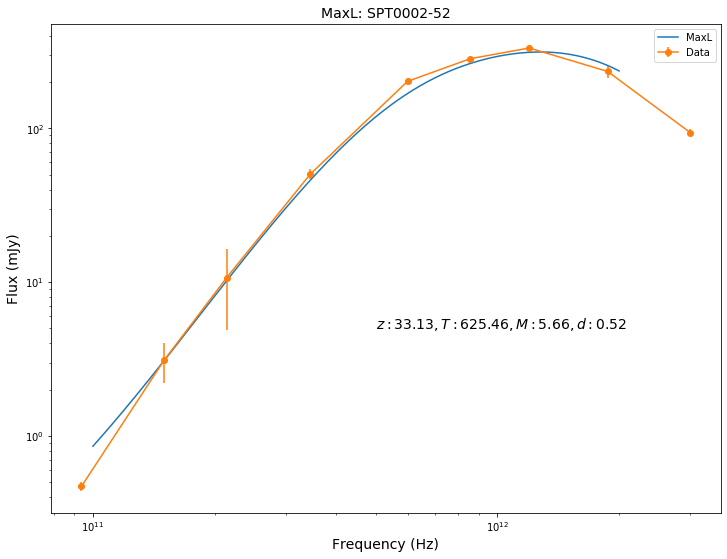

In [1138]:
ml(ID[0],z_ref,Tc_ref,M_ref,d_ref,frecs0T,errf0T)

In [1139]:
mcmc(ID[0],z_ref,Tc_ref,M_ref,d_ref,frecs0T,errf0T)

KeyboardInterrupt: 